# <center>Recurrent Neural Networks</center>
## <center>Inclass Project 3 - MA4144</center>

This project contains multiple tasks to be completed, some require written answers. Questions that required written answers are given in blue fonts. Almost all written questions are open ended, they do not have a correct or wrong answer. You are free to give your opinions, but please provide related answers within the context.

After finishing project run the entire notebook once and **save the notebook as a pdf** (File menu -> Save and Export Notebook As -> PDF). You are **required to upload both this ipynb file and the PDF on moodle**.

***

## Outline of the project

The aim of the project is to build a RNN model to suggest autocompletion of half typed words. You may have seen this in many day today applications; typing an email, a text message etc. For example, suppose you type in the four letter "univ", the application may suggest you to autocomplete it by "university".

![Autocomplete](https://d33v4339jhl8k0.cloudfront.net/docs/assets/5c12e83004286304a71d5b72/images/66d0cb106eb51e63b8f9fbc6/file-gBQe016VYt.gif)

We will train a RNN to suggest possible autocompletes given $3$ - $4$ starting letters. That is if we input a string "univ" hopefully we expect to see an output like "university", "universal" etc.

For this we will use a text file (wordlist.txt) containing 10,000 common English words (you'll find the file on the moodle link). The list of words will be the "**vocabulary**" for our model.

We will use the Python **torch library** to implement our autocomplete model. 

***


Use the below cell to use any include any imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cpu


## Section 1: Preparing the vocabulary

In [2]:
WORD_SIZE = 13

**Q1.** In the following cell provide code to load the text file (each word is in a newline), then extract the words (in lowercase) into a list.

For practical reasons of training the model we will only use words that are longer that $3$ letters and that have a maximum length of WORD_SIZE (this will be a constant we set at the beginning - you can change this and experiment with different WORD_SIZEs). As seen above it is set to $13$.

So out of the extracted list of words filter out those words that match our criteria on word length.

To train our model it is convenient to have words/strings of equal length. We will choose to convert every word to length of WORD_SIZE, by adding underscores to the end of the word if it is initially shorter than WORD_SIZE. For example, we will convert the word "university" (word length 10) into "university___" (wordlength 13). In your code include this conversion as well.

Store the processed WORD_SIZE lengthed strings in a list called vocab.

In [3]:
#TODO
def load_vocab():
    vocab = []
    with open('wordlist.txt', 'r', encoding='utf-8') as f:
        words = [line.strip().lower() for line in f if line.strip()]
        
    for word in words:
        if 3 < len(word) <= WORD_SIZE:
            # Pad with underscores to make all words WORD_SIZE length
            padded_word = word + '_' * (WORD_SIZE - len(word))
            vocab.append(padded_word)
        
    return vocab
    

vocab = load_vocab()
print(f"Vocabulary size: {len(vocab)}")
print(f"Sample words: {vocab[:5]}")

Vocabulary size: 8847
Sample words: ['aaron________', 'abandoned____', 'aberdeen_____', 'abilities____', 'ability______']


<font color='blue'>In the above explanation it was mentioned "for practical reasons of training the model we will only use words that are longer that $3$ letters and that have a certain maximum length". In your opinion what could be those practical? Will hit help to build a better model?</font>

The practical reasons for filtering word lengths include training efficiency, since very short words (≤3 letters) don't provide enough sequential pattern information for the RNN to learn meaningful character relationships, while very long words would require longer sequence processing and increase memory usage and training time significantly. By capping at WORD_SIZE (13), we keep computational costs manageable and ensure fixed input sizes that allow neural networks to work more efficiently with consistent tensor operations and batch processing. Words of similar lengths tend to have similar structural patterns, which helps the model learn better character transition probabilities, and limiting sequence length prevents vanishing gradient problems common in RNNs when processing very long sequences. This approach will help build a better model because it allows focused learning on patterns within a reasonable word length range rather than trying to handle everything from 1-letter to 20+ letter words, enables better generalization to unseen words of similar length, reduces noise by filtering out very short words that don't contribute meaningful sequential information, and provides more consistent performance on words within the trained length range, though it does limit the model's ability to autocomplete words outside this range.

**Q2** To input words into the model, we will need to convert each letter/character into a number. as we have seen above, the only characters in our list vocab will be the underscore and lowercase english letters. so we will convert these $27$ characters into numbers as follows: underscore -> $0$, 'a' -> $1$, 'b' -> $2$, $\cdots$, 'z' -> $26$. In the following cell,

(i) Implement a method called char_to_num, that takes in a valid character and outputs its numerical assignment.

(ii) Implement a method called num_to_char, that takes in a valid number from $0$ to $26$ and outputs the corresponding character.

(iii) Implement a method called word_to_numlist, that takes in a word from our vocabulary and outputs a (torch) tensor of numbers that corresponds to each character in the word in that order. For example: the word "united_______" will be converted to tensor([21, 14,  9, 20,  5,  4,  0,  0,  0,  0,  0,  0,  0]). You are encouraged to use your char_to_num method for this.

(iv) Implement a method called numlist_to_word, that does the opposite of the above described word_to_numlist, given a tensor of numbers from $0$ to $26$, outputs the corresponding word. You are encouraged to use your  num_to_char method for this.

Note: As mentioned since we are using the torch library we will be using tensors instead of the usual python lists or numpy arrays. Tensors are the list equivalent in torch. Torch models only accept tensors as input and they output tensors.

In [4]:
def char_to_num(char):
    if char == '_':
        return 0
    if 'a' <= char <= 'z':
        return ord(char) - ord('a') + 1
    raise ValueError(f"Invalid character: {char!r}")

def num_to_char(num):
    idx = int(num)
    if idx == 0:
        return '_'
    if 1 <= idx <= 26:
        return chr(ord('a') + idx - 1)
    raise ValueError(f"Invalid index: {num}")

def word_to_numlist(word):
    nums = [char_to_num(c) for c in word]
    return torch.tensor(nums, dtype=torch.long)

def numlist_to_word(numlist):
    seq = numlist.tolist() if hasattr(numlist, 'tolist') else list(numlist)
    chars = [num_to_char(n) for n in seq]
    return ''.join(chars)

<font color='blue'>We convert letter into just numbers based on their aphabetical order, I claim that it is a very bad way to encode data such as letters to be fed into learning models, please write your explanation to or against my claim. If you are searching for reasons, the keyword 'categorical data' may be useful. Although the letters in our case are not treated as categorical data, the same reasons as for categorical data is applicable. Even if my claim is valid, at the end it won't matter due to something called "embedding layers" that we will use in our model. What is an embedding layer? What is it's purpose? Explain.</font> (write answers in the cell below as a string)

In [5]:
#Write answer here as strings:

answer_ = "I agree with your claim that converting letters to numbers based on alphabetical order is a suboptimal encoding method for machine learning models. This approach creates artificial ordinal relationships between letters where none should exist - for example, it implies that 'b' (2) is somehow 'twice as much' as 'a' (1), or that 'z' (26) is arithmetically related to 'a' (1) in a meaningful way. This is problematic because letters are categorical data, not ordinal data, meaning they represent distinct categories without any inherent numerical relationship or hierarchy. When we encode categorical data as simple integers, we introduce spurious mathematical relationships that can mislead the learning algorithm into finding patterns based on these artificial numerical distances rather than the actual linguistic relationships between letters. However, as you correctly point out, this issue is resolved by using embedding layers in our neural network. An embedding layer is a learnable lookup table that maps each integer (representing a character) to a dense vector of real numbers in a high-dimensional space. The purpose of the embedding layer is to learn meaningful representations of characters during training, where characters that appear in similar contexts or have similar roles in language will have similar vector representations. Unlike the arbitrary numerical ordering we initially assign, these learned embeddings capture semantic relationships - for example, vowels might cluster together in the embedding space, or consonants with similar sounds might have similar representations. The embedding layer essentially transforms our crude integer encoding into rich, context-aware representations that the LSTM can effectively use to understand character sequences and predict the next character in a word. This is why the initial integer encoding doesn't ultimately harm the model's performance - the embedding layer learns to ignore the arbitrary numerical ordering and creates its own meaningful character representations."

## Section 2: Implementing the Autocomplete model

We will implement a RNN LSTM model. The [video tutorial](https://www.youtube.com/watch?v=tL5puCeDr-o) will be useful. Our model will be only one hidden layer, but feel free to sophisticate with more layers after the project for your own experiments.

Our model will contain all the training and prediction methods as single package in a class (autocompleteModel) we will define and implement below.

In [6]:
LEARNING_RATE = 0.001

In [7]:
class autocompleteModel(nn.Module):
    def __init__(self, alphabet_size, embed_dim, hidden_size, num_layers):
        super().__init__()
        self.alphabet_size = alphabet_size
        self.embed_dim = embed_dim
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.word_size = WORD_SIZE

        # Improved architecture with dropout for regularization
        self.embedding = nn.Embedding(self.alphabet_size, self.embed_dim)
        self.dropout = nn.Dropout(0.2)  # Add dropout for regularization
        
        # Use LSTM instead of LSTMCell for batch processing
        self.lstm = nn.LSTM(self.embed_dim, self.hidden_size, self.num_layers, 
                           batch_first=True, dropout=0.2 if num_layers > 1 else 0)
        
        self.fc = nn.Linear(self.hidden_size, self.alphabet_size)
        self.criterion = nn.CrossEntropyLoss()
        
        # Initialize weights
        self.init_weights()
        self.to(device)

    def init_weights(self):
        """Initialize weights for better training"""
        for name, param in self.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)

    def forward(self, input_seq, hidden_state=None):
        """
        Forward pass for sequence processing
        input_seq: (batch_size, seq_len)
        """
        batch_size, seq_len = input_seq.size()
        
        # Embedding
        embedded = self.embedding(input_seq)  # (batch_size, seq_len, embed_dim)
        embedded = self.dropout(embedded)
        
        # LSTM
        if hidden_state is None:
            hidden_state = self.init_hidden(batch_size)
            
        lstm_out, hidden_state = self.lstm(embedded, hidden_state)
        
        # Apply dropout and linear layer
        output = self.fc(lstm_out)  # (batch_size, seq_len, alphabet_size)
        
        return output, hidden_state

    def init_hidden(self, batch_size):
        """Initialize hidden state"""
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device)
        return (h0, c0)

    def trainModel(self, vocab, epochs=5, batch_size=64):
        """Improved training with better batching"""
        self.train()
        
        # Use learning rate scheduler
        optimizer = optim.Adam(self.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.8)
        
        loss_log = []
        
        for epoch in range(1, epochs+1):
            random.shuffle(vocab)
            epoch_loss = 0.0
            num_batches = 0
            
            # Process in batches
            for i in range(0, len(vocab), batch_size):
                batch_words = vocab[i:i+batch_size]
                if len(batch_words) < batch_size:
                    continue  # Skip incomplete batches
                    
                optimizer.zero_grad()
                
                # Convert batch to tensors
                batch_input = []
                batch_target = []
                
                for word in batch_words:
                    seq = word_to_numlist(word)
                    batch_input.append(seq[:-1])  # All but last char
                    batch_target.append(seq[1:])  # All but first char
                
                batch_input = torch.stack(batch_input).to(device)   # (batch_size, seq_len)
                batch_target = torch.stack(batch_target).to(device) # (batch_size, seq_len)
                
                # Forward pass
                outputs, _ = self.forward(batch_input)
                
                # Reshape for loss calculation
                outputs = outputs.view(-1, self.alphabet_size)  # (batch_size * seq_len, alphabet_size)
                batch_target = batch_target.view(-1)            # (batch_size * seq_len)
                
                # Calculate loss
                loss = self.criterion(outputs, batch_target)
                
                # Backward pass
                loss.backward()
                
                # Gradient clipping to prevent exploding gradients
                torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)
                
                optimizer.step()
                
                epoch_loss += loss.item()
                num_batches += 1
                loss_log.append(loss.item())
            
            # Update learning rate
            scheduler.step()
            
            avg_epoch_loss = epoch_loss / num_batches if num_batches > 0 else 0
            print(f"Epoch {epoch}/{epochs}, Loss: {avg_epoch_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")

        # Plot training loss
        plt.figure(figsize=(10, 6))
        plt.plot(loss_log)
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.title("Training Loss")
        plt.grid(True)
        plt.show()

    def autocomplete(self, samples, temperature=0.8, max_length=None):
        """
        Improved autocomplete with better sampling strategies
        """
        self.eval()
        completed = []
        
        if max_length is None:
            max_length = self.word_size

        with torch.no_grad():
            for sample in samples:
                sample = sample.lower()
                
                # Convert sample to tensor
                input_seq = torch.tensor([char_to_num(c) for c in sample], 
                                       dtype=torch.long, device=device).unsqueeze(0)
                
                # Get hidden state after processing the sample
                _, hidden = self.forward(input_seq)
                
                # Generate remaining characters
                generated = sample
                current_input = torch.tensor([[char_to_num(sample[-1])]], 
                                           dtype=torch.long, device=device)
                
                for _ in range(max_length - len(sample)):
                    # Forward pass
                    output, hidden = self.forward(current_input, hidden)
                    
                    # Apply temperature and get probabilities
                    logits = output[0, -1, :] / temperature
                    probs = torch.softmax(logits, dim=0)
                    
                    # Sample next character (with top-k sampling for better results)
                    top_k = min(5, len(probs))
                    top_probs, top_indices = torch.topk(probs, top_k)
                    top_probs = top_probs / torch.sum(top_probs)  # Renormalize
                    
                    # Sample from top-k
                    selected_idx = torch.multinomial(top_probs, 1).item()
                    next_char_idx = top_indices[selected_idx].item()
                    next_char = num_to_char(next_char_idx)
                    
                    # Stop if we hit padding or reach reasonable length
                    if next_char == '_' or len(generated) >= 15:
                        break
                    
                    generated += next_char
                    current_input = torch.tensor([[next_char_idx]], 
                                               dtype=torch.long, device=device)
                
                completed.append(generated)
        
        return completed


## Section 3: Using and evaluating the model

(i) Initialize and train autocompleteModels using different embedding dimensions and hidden layer sizes. Use different learning rates, epochs, batch sizes. Train the best model you can.

(ii) Evaluate it on different samples of partially filled in words to test your model. Eg: ["univ", "math", "neur", "engin"] etc.

(iii) Set your best model, to the variable best_model. This model will be tested against random inputs (3-4 starting strings of common English words). **This will be the main contributor for your score in this project**.

Training improved model...
Epoch 1/5, Loss: 1.7215, LR: 0.001000
Epoch 2/5, Loss: 1.3730, LR: 0.000800
Epoch 3/5, Loss: 1.2800, LR: 0.000800
Epoch 4/5, Loss: 1.2264, LR: 0.000640
Epoch 5/5, Loss: 1.1868, LR: 0.000640


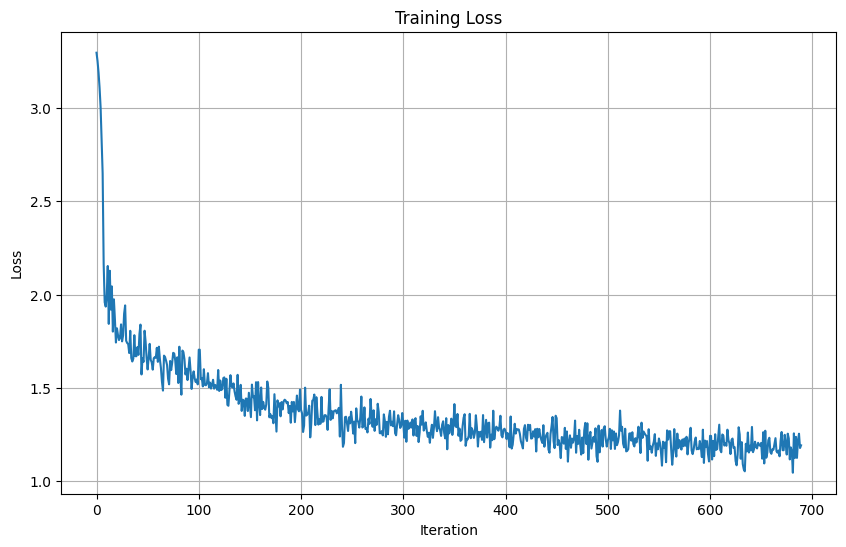


Testing improved autocomplete:
univ -> unives
math -> mathess
neur -> neur
engin -> engin
comp -> compection
algo -> algon


In [8]:
# Training and evaluation
print("Training improved model...")

# Use optimized hyperparameters
model = autocompleteModel(
    alphabet_size=27, 
    embed_dim=125,      # Balanced embedding size
    hidden_size=256,    # Reasonable hidden size
    num_layers=2        # 2 layers for better learning
)

# Train with better parameters
model.trainModel(vocab, epochs=5, batch_size=64)

# Test the model
test_samples = ["univ", "math", "neur", "engin", "comp", "algo"]
print("\nTesting improved autocomplete:")
results = model.autocomplete(test_samples, temperature=0.6)

for inp, out in zip(test_samples, results):
    print(f"{inp} -> {out}")

# Set as best model
best_model = model